In [1]:
!pip install keras_cv==0.5.0 wandb -q
!pip install -U keras-cv-attention-models -q

In [2]:
import os
import warnings
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g.  pd.read_csv)
from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn import linear_model, model_selection


import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.python.client import device_lib

import keras_cv as kcv
from keras_cv import visualization
from keras_cv.models import ResNet18Backbone

from kaggle_secrets import UserSecretsClient
import wandb
from datetime import datetime

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# Setup user secrets for login
user_secrets = UserSecretsClient()
wandb_api = user_secrets.get_secret("api_key") 
wandb.login(key=wandb_api)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [4]:
from wandb.keras import WandbCallback, WandbMetricsLogger
run = wandb.init(project = 'neurips',
                 save_code = True,
                 name='coatnet'
                 
)

wandb: Currently logged in as: devanshu-tayal (devanshu1). Use `wandb login --relogin` to force relogin


# Device Configuration

In [5]:
def set_device(mixed_precision=True, set_jit=False):
    # printed out the detected devices
    list_ld = device_lib.list_local_devices()
    for dev in list_ld: 
        print(dev.name,dev.memory_limit)

    # get the lisf of physical devices
    physical_devices = tf.config.list_physical_devices(
        'GPU' if len(list_ld) - 1 else 'CPU'
    )
    # For GPU devices, configure related stuff
    if 'GPU' in physical_devices[-1]:
        tf.config.optimizer.set_jit(set_jit)
        if mixed_precision:
            keras.mixed_precision.set_global_policy(
                "mixed_float16"
            )
        else:
            keras.mixed_precision.set_global_policy(
                keras.backend.floatx()
            )
        for pd in physical_devices:
            tf.config.experimental.set_memory_growth(
                pd, True
            )
    strategy = tf.distribute.MirroredStrategy()
    return (strategy, physical_devices)

In [6]:
strategy, physical_devices = set_device(mixed_precision=True, set_jit=True)
physical_devices, strategy, tf.__version__

/device:CPU:0 268435456
/device:GPU:0 16059727872


([PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')],
 '2.12.0')

# Data Pipeline 

In [7]:
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 128

(x_train, y_train), held_out = keras.datasets.cifar10.load_data()
test_set, val_set = keras.utils.split_dataset(held_out, left_size=0.2)

170498071/170498071 [==============================] - 5s 0us/step


/opt/conda/lib/python3.10/site-packages/keras/utils/dataset_utils.py:157: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.array(sample)


In [8]:
def normalize(image, label, denorm=False):
    rescale = keras.layers.Rescaling(scale=1./255.)
    norms = keras.layers.Normalization(
        mean=[0.4914, 0.4822, 0.4465], 
        variance=[np.square(0.2023), np.square(0.1994), np.square(0.2010)], 
        invert=denorm,
        axis=-1,
    )
    
    if not denorm:
        image = rescale(image)
    return norms(image), label

In [9]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.map(normalize)
train_ds = train_ds.shuffle(buffer_size=8*BATCH_SIZE)
train_ds = train_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

val_ds = val_set.map(normalize).batch(BATCH_SIZE).prefetch(AUTOTUNE)
test_ds = test_set.map(normalize).batch(BATCH_SIZE).prefetch(AUTOTUNE)

(128, 32, 32, 3) (128, 1)


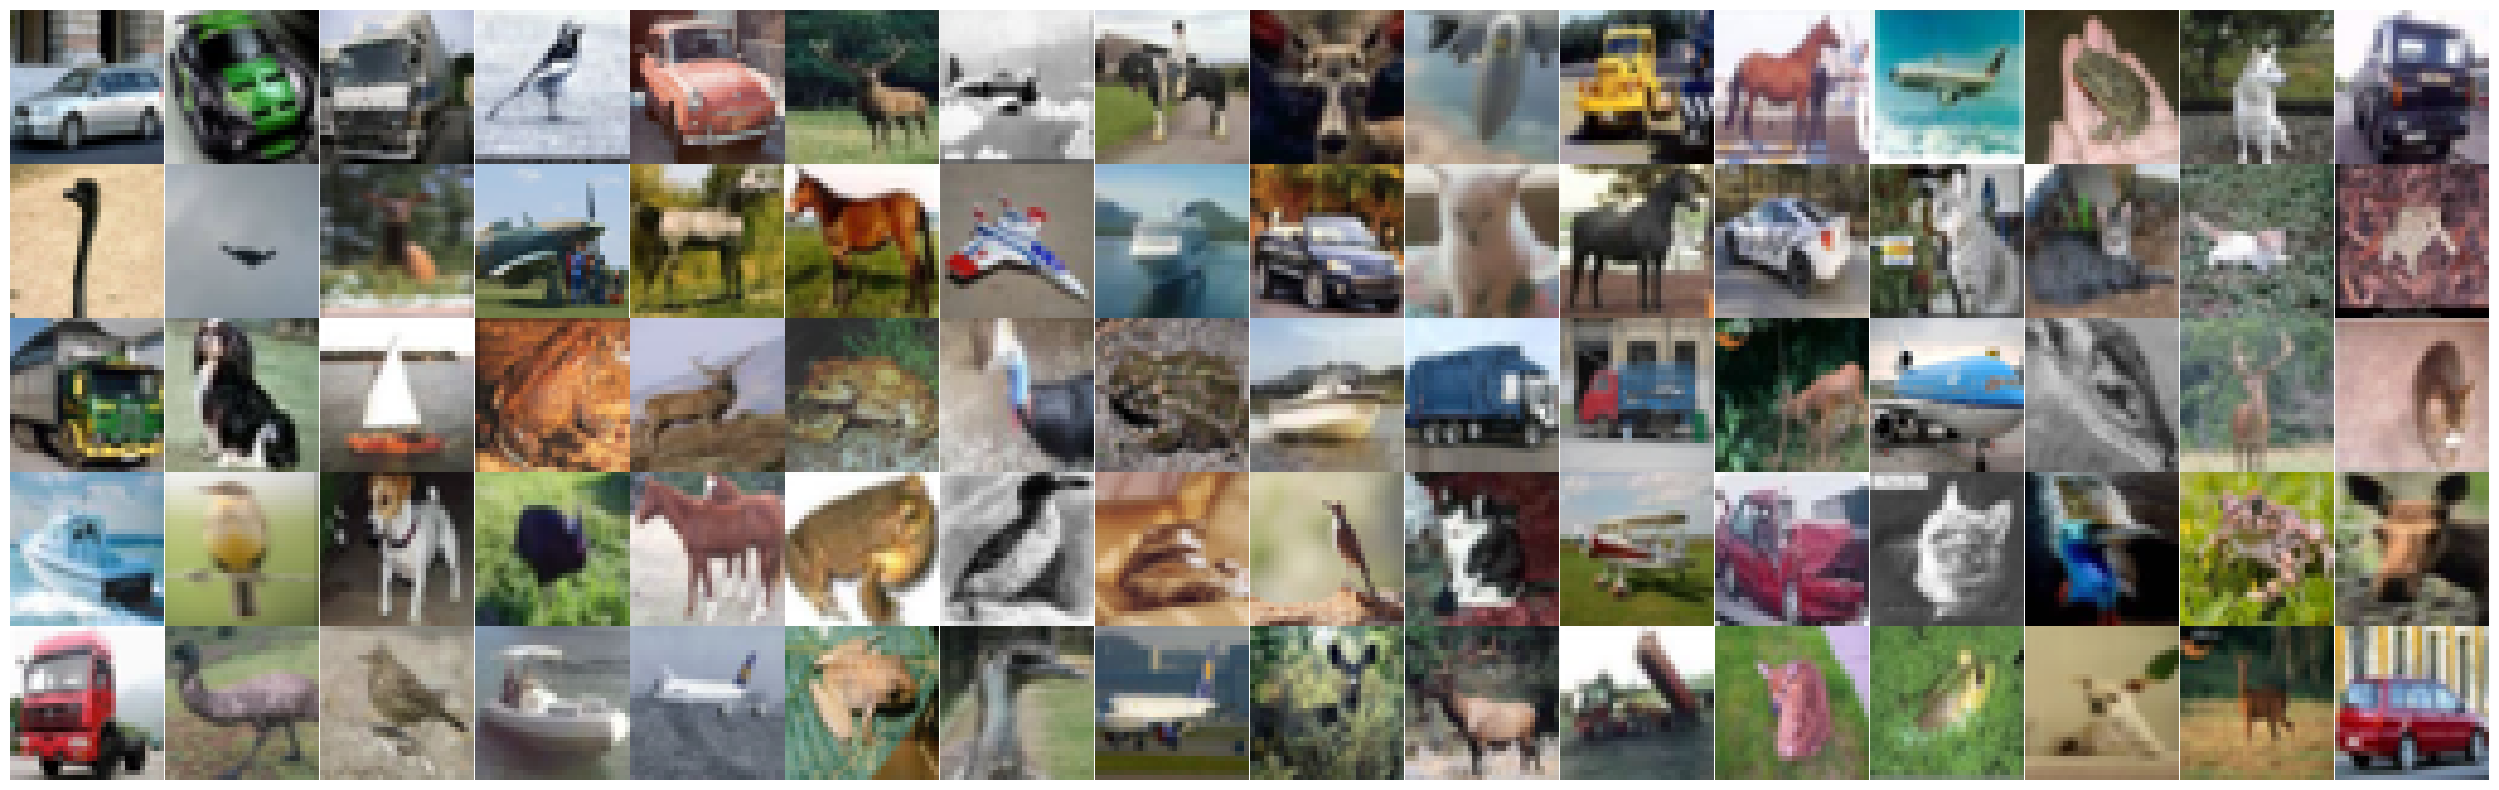

In [10]:
temp_ds = train_ds.map(lambda x,y:normalize(x,y, denorm=True))
images, labels = next(iter(temp_ds))
print(images.shape, labels.shape)

visualization.plot_image_gallery(
    images, value_range=(0, 1), rows=5, cols=16
)

# CoAtNet 

In [11]:
from keras_cv_attention_models import coatnet
def get_model():
    with strategy.scope():
        model = keras.Sequential(
            [
                coatnet.CoAtNet0(num_classes=0,input_shape=(32,32,3),pretrained=None),
                keras.layers.GlobalMaxPooling2D(),
                keras.layers.Dense(10, activation="softmax", dtype=tf.float32),
            ]
        )
        model.compile(
            optimizer='adam', 
            loss='sparse_categorical_crossentropy', 
            metrics=metrics.SparseCategoricalAccuracy(name='accuracy'),
            jit_compile=True
        )
    
    return model

In [12]:
model = get_model()
model.fit(train_ds, validation_data=val_ds, epochs=2, callbacks=[WandbMetricsLogger()])
model.save("coat_cifat10.keras", save_format="keras_v3")

Epoch 1/2
391/391 [==============================] - 145s 208ms/step - loss: 4.7087 - accuracy: 0.3883 - val_loss: 2.1153 - val_accuracy: 0.3914
Epoch 2/2
391/391 [==============================] - 30s 77ms/step - loss: 1.2376 - accuracy: 0.5779 - val_loss: 1.1524 - val_accuracy: 0.6086


In [13]:
print(f"Train set accuracy: {100.0 * model.evaluate(train_ds)[-1]:0.1f}%%")
print(f"Test set accuracy: {100.0 * model.evaluate(test_ds)[-1]:0.1f}%%")

391/391 [==============================] - 12s 29ms/step - loss: 0.9873 - accuracy: 0.6515
Train set accuracy: 65.1%%
16/16 [==============================] - 0s 17ms/step - loss: 1.1516 - accuracy: 0.6160
Test set accuracy: 61.6%%


In [14]:
forget_set, retain_set = keras.utils.split_dataset(train_ds.unbatch(), left_size=0.1)
forget_ds = forget_set.batch(BATCH_SIZE).prefetch(AUTOTUNE)
retain_ds = retain_set.batch(BATCH_SIZE).prefetch(AUTOTUNE)
int(forget_ds.cardinality()), int(retain_ds.cardinality())

(40, 352)

In [15]:
def unlearning(net, retain, forget, validation):

    epochs = 5
 
    with strategy.scope():
        # loss, metric, scheduler, optimizer
        loss = losses.SparseCategoricalCrossentropy()
        metric = metrics.SparseCategoricalAccuracy(name='accuracy')
        sched = optimizers.schedules.CosineDecay(
            initial_learning_rate=0.1, decay_steps=retain.cardinality() * epochs
        )
        optim = optimizers.SGD(
            learning_rate=sched, momentum=0.9, weight_decay=5e-4
        )
        
        # compile the model
        net.compile(
            optimizer=optim, 
            loss=loss, 
            metrics=metric,
        )

    # training
    net.fit(retain,verbose=1, epochs=epochs,callbacks=[WandbMetricsLogger()])
    
    return net

In [16]:
with strategy.scope():
    # load pre-trained model
    net = keras.models.load_model("/kaggle/working/coat_cifat10.keras")

# Execute the unlearing routine. This might take a few minutes.
# If run on colab, be sure to be running it on  an instance with GPUs
model_ft = unlearning(net, retain_ds, forget_ds, test_ds)

Epoch 1/5
352/352 [==============================] - 80s 78ms/step - loss: nan - accuracy: 0.1021
Epoch 2/5
352/352 [==============================] - 53s 151ms/step - loss: nan - accuracy: 0.1000
Epoch 3/5
352/352 [==============================] - 23s 65ms/step - loss: nan - accuracy: 0.1000
Epoch 4/5
352/352 [==============================] - 23s 64ms/step - loss: nan - accuracy: 0.1000
Epoch 5/5
352/352 [==============================] - 23s 64ms/step - loss: nan - accuracy: 0.1000


In [17]:
print(f"Retain set accuracy: {100.0 * model_ft.evaluate(retain_ds)[-1]:0.1f}%%")
print(f"Test set accuracy: {100.0 * model_ft.evaluate(test_ds)[-1]:0.1f}%%")

352/352 [==============================] - 13s 15ms/step - loss: nan - accuracy: 0.1000
Retain set accuracy: 10.0%%
16/16 [==============================] - 1s 55ms/step - loss: nan - accuracy: 0.1020
Test set accuracy: 10.2%%


In [18]:
run.finish()

wandb: WARNING Source type is set to 'artifact' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


epoch/accuracy,▅█▁▁▁▁▁
epoch/epoch,▁▃▁▃▅▆█
epoch/learning_rate,▁▁█████
epoch/loss,█▁
epoch/val_accuracy,▁█
epoch/val_loss,█▁
epoch/accuracy,0.09996
epoch/epoch,4
epoch/learning_rate,0.09998
epoch/loss,nan
epoch/val_accuracy,0.60862


# EfficientFormerV2

In [19]:
from wandb.keras import WandbCallback, WandbMetricsLogger
run = wandb.init(project = 'neurips',
                 save_code = True,
                 name='EfficientFormerV2S'
                 
)

In [20]:
from keras_cv_attention_models import efficientformer
def get_model():
        model = keras.Sequential(
            [
                efficientformer.EfficientFormerV2S0(num_classes=0,input_shape=(32,32,3),pretrained=None),
                keras.layers.GlobalMaxPooling2D(),
                keras.layers.Dense(10, activation="softmax", dtype=tf.float32),
            ]
        )
        model.summary()
        model.compile(
            optimizer='adam', 
            loss='sparse_categorical_crossentropy', 
            metrics=metrics.SparseCategoricalAccuracy(name='accuracy'),
        )
    
        return model
model = get_model()
model.fit(train_ds, validation_data=val_ds, epochs=20, callbacks=[WandbMetricsLogger()])
model.save("EfficientFormerV2S_cifat10.keras", save_format="keras_v3")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientformer_v2_s0 (Func  (None, 1, 1, 176)        3291792   
 tional)                                                         
                                                                 
 global_max_pooling2d_1 (Glo  (None, 176)              0         
 balMaxPooling2D)                                                
                                                                 
 dense_1 (Dense)             (None, 10)                1770      
                                                                 
Total params: 3,293,562
Trainable params: 3,244,602
Non-trainable params: 48,960
_________________________________________________________________
Epoch 1/20
391/391 [==============================] - 180s 114ms/step - loss: 1.5057 - accuracy: 0.4762 - val_loss: 1.2335 - val_accuracy: 0.5530
Epoch 2/20
391/391 [=====

In [21]:
print(f"Train set accuracy: {100.0 * model.evaluate(train_ds)[-1]:0.1f}%%")
print(f"Test set accuracy: {100.0 * model.evaluate(test_ds)[-1]:0.1f}%%")

391/391 [==============================] - 5s 12ms/step - loss: 0.0774 - accuracy: 0.9738
Train set accuracy: 97.4%%
16/16 [==============================] - 6s 381ms/step - loss: 1.6110 - accuracy: 0.7230
Test set accuracy: 72.3%%


In [22]:
forget_set, retain_set = keras.utils.split_dataset(train_ds.unbatch(), left_size=0.1)
forget_ds = forget_set.batch(BATCH_SIZE).prefetch(AUTOTUNE)
retain_ds = retain_set.batch(BATCH_SIZE).prefetch(AUTOTUNE)

In [23]:
int(forget_ds.cardinality()), int(retain_ds.cardinality())

def unlearning(net, retain, forget, validation):

        epochs = 5
 
        # loss, metric, scheduler, optimizer
        loss = losses.SparseCategoricalCrossentropy()
        metric = metrics.SparseCategoricalAccuracy(name='accuracy')
        sched = optimizers.schedules.CosineDecay(
            initial_learning_rate=0.1, decay_steps=retain.cardinality() * epochs
        )
        optim = optimizers.SGD(
            learning_rate=sched, momentum=0.9, weight_decay=5e-4
        )
        
        # compile the model
        net.compile(
            optimizer=optim, 
            loss=loss, 
            metrics=metric,
        )

    # training
        net.fit(retain, epochs=epochs,callbacks=[WandbMetricsLogger()])
    
        return net

In [24]:
    # load pre-trained model
net = keras.models.load_model("EfficientFormerV2S_cifat10.keras")

# Execute the unlearing routine. This might take a few minutes.
# If run on colab, be sure to be running it on  an instance with GPUs
model_ft = unlearning(net, retain_ds, forget_ds, test_ds)

Epoch 1/5
352/352 [==============================] - 125s 84ms/step - loss: 1.4575 - accuracy: 0.4971
Epoch 2/5
352/352 [==============================] - 72s 204ms/step - loss: 0.9031 - accuracy: 0.6797
Epoch 3/5
352/352 [==============================] - 26s 73ms/step - loss: 0.6002 - accuracy: 0.7885
Epoch 4/5
352/352 [==============================] - 26s 73ms/step - loss: 0.3579 - accuracy: 0.8756
Epoch 5/5
352/352 [==============================] - 25s 72ms/step - loss: 0.1722 - accuracy: 0.9424


In [25]:
print(f"Retain set accuracy: {100.0 * model_ft.evaluate(retain_ds)[-1]:0.1f}%%")
print(f"Test set accuracy: {100.0 * model_ft.evaluate(test_ds)[-1]:0.1f}%%")

352/352 [==============================] - 11s 12ms/step - loss: 0.1363 - accuracy: 0.9581
Retain set accuracy: 95.8%%
16/16 [==============================] - 0s 14ms/step - loss: 1.1452 - accuracy: 0.7145
Test set accuracy: 71.5%%


In [26]:
run.finish()

wandb: WARNING Source type is set to 'artifact' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


epoch/accuracy,▁▃▄▅▅▆▆▇▇▇▇█████████▁▄▅▇█
epoch/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██▁▁▂▂▂
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▆▄▂▁
epoch/loss,█▆▅▄▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁█▅▄▂▁
epoch/val_accuracy,▁▅▆▇█▇▇▇▇▇█████▇████
epoch/val_loss,▄▂▁▁▁▂▃▄▄▅▅▆▆▆▆▇▇▇▇█
epoch/accuracy,0.94242
epoch/epoch,4
epoch/learning_rate,0.0
epoch/loss,0.17224
epoch/val_accuracy,0.70512
